In [ ]:
# from PyQt5.QtCore import QT_VERSION_STR

In [166]:
%matplotlib inline
# %matplotlib qt 
import matplotlib
matplotlib.use('Qt5Agg')
import itertools as iter
# Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins.ffmpeg.download()
from skimage.transform import SimilarityTransform
from skimage.transform import rotate, warp

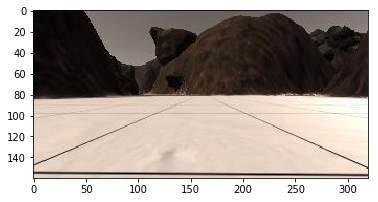

In [3]:
path = '../collected_images/IMG/robocam_2017_12_06_05_49_10_984.jpg'
image = mpimg.imread(path)
plt.imshow(image)

Below seems to produce a slightly rotated transformation look at later if need be

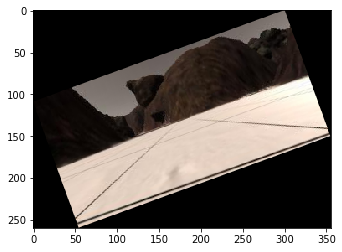

In [147]:
transed = transform.rotate(image, angle=20, resize=True, center=(160, 160), order=1, mode='constant', cval=0, clip=True, preserve_range=False)
plt.imshow(transed)

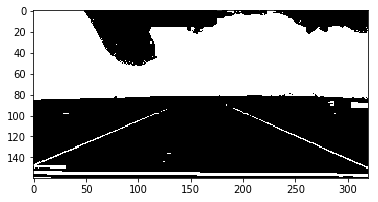

In [43]:
def hsv_color_select(frame):
    hsv_image = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    lower_trad_hsv = [10.,0.,75.]
    upper_trad_hsv = [70.,18.,100.]
    # gpick uses different scale for HSV values than cv2
    lower_ground = np.array([lower_trad_hsv[0] / 2,(lower_trad_hsv[1] / 100) * 255, (lower_trad_hsv[2] / 100) * 255])
    upper_ground = np.array([upper_trad_hsv[0] / 2,(upper_trad_hsv[1] / 100) * 255, (upper_trad_hsv[2] / 100) * 255])

    lower_trad_hsv = [5.,5.,40.]
    upper_trad_hsv = [45.,15.,60.]
    lower_sky = np.array([lower_trad_hsv[0] / 2,(lower_trad_hsv[1] / 100) * 255, (lower_trad_hsv[2] / 100) * 255])
    upper_sky = np.array([upper_trad_hsv[0] / 2,(upper_trad_hsv[1] / 100) * 255, (upper_trad_hsv[2] / 100) * 255])
    
    ground_mask = cv2.inRange(hsv_image, lower_ground, upper_ground).astype(np.bool)
    sky_mask = cv2.inRange(hsv_image, lower_sky, upper_sky).astype(np.bool)
    walls_mask = np.bitwise_not(np.bitwise_or(ground_mask, sky_mask))
    return ground_mask.astype(np.float32), walls_mask.astype(np.float32)

ground_masked, walls_masked = hsv_color_select(image)

plt.imshow(walls_masked, cmap='gray')

In [44]:
ground_masked[ground_masked > 0]

array([ 1.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

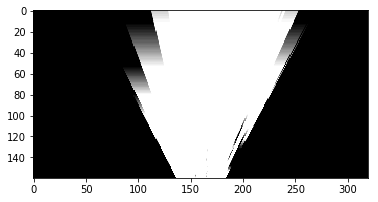

In [148]:
def perspect_transform(img, src, dst):           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    return warped

# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
map_grid_side = 10
dst_size = map_grid_side / 2 
# Set a bottom offset to account for the fact that the bottom of the image 
bottom_offset = 2
source = np.float32([[118, 99], [203, 99], [182, 90], [136, 90]])
destination = np.float32([
    [image.shape[1]/2 - dst_size, image.shape[0] + map_grid_side - bottom_offset],
    [image.shape[1]/2 + dst_size, image.shape[0] + map_grid_side - bottom_offset],
    [image.shape[1]/2 + dst_size, image.shape[0] - map_grid_side - 2*dst_size - bottom_offset], 
    [image.shape[1]/2 - dst_size, image.shape[0] - map_grid_side - 2*dst_size - bottom_offset],
])
# warped = perspect_transform(threshed, source, destination)
ground_warped = perspect_transform(ground_masked, source, destination)
walls_warped = perspect_transform(walls_masked, source, destination)

plt.imshow(ground_warped, cmap='gray')
# plt.imshow(walls_warped, cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)

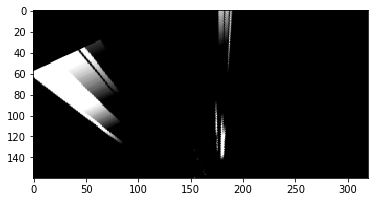

In [156]:
transed = transform.rotate(walls_warped, angle=25, resize=False, center=(160, 160), order=1, mode='constant', cval=0, clip=True, preserve_range=False)
plt.imshow(transed, cmap='gray')

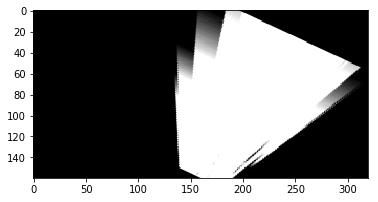

In [159]:
transed = transform.rotate(ground_warped, angle=-25, resize=False, center=(160, 160), order=1, mode='constant', cval=0, clip=True, preserve_range=True)
plt.imshow(transed, cmap='gray')

In [119]:
# main map, 10 elements per meter simulation world, estimated necessary size, see below for 
#  potential expanding version implementation below
main_map = np.zeros((4000, 4000, 3), dtype=np.int8)
origin = (np.int(np.floor(main_map.shape[0] / 2)), np.int(np.floor(main_map.shape[0] / 2)))
print(origin)
view_size_x, view_size_y = image.shape[:2]
x_half = view_size_x / 2
y_half = view_size_y / 2
print(view_size_x, view_size_y)
# plt.imshow(main_map, cmap='gray')

(2000, 2000)
(160, 320)


In [120]:
initial_coords = (_,_) # <- get from telemetry once at beginning
current_coords = (_,_) # <- get from telemetry each time

# BIG TODO: NEED TO TAKE INTERSECTION OF TWO AND PREFER PATH WHERE THERES OVERLAP

In [121]:
# add walls to current_map_section
main_map[:,:,1][origin[0]-x_half:origin[0]+x_half, origin[1]:origin[1]+y_half*2] = np.bitwise_or(
    main_map[:,:,1][origin[0]-x_half:origin[0]+x_half, origin[1]:origin[1]+y_half*2], walls_warped.astype(np.int8))

# add path current_map_section
main_map[:,:,0][origin[0]-x_half:origin[0]+x_half, origin[1]:origin[1]+y_half*2] = 100*np.bitwise_or(
    main_map[:,:,0][origin[0]-x_half:origin[0]+x_half, origin[1]:origin[1]+y_half*2], ground_warped.astype(np.int8))

plt.imshow(main_map[origin[0]-x_half:origin[0]+x_half, origin[1]:origin[1]+y_half*2])

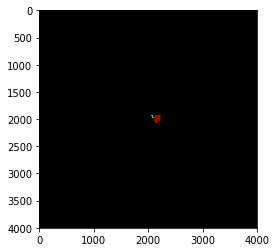

In [124]:
plt.imshow(main_map, cmap='gray')


# THIS ABOVE NEEDS TO BE VERIFIED AGAINST BOTH AND OVERHEAD SHOT FROM THE SIM, AS WELL AS IN OTHER, LESS SPACIOUS CONDITIONS

# TODO: Take a second threshold with the colors of the rocks, to create blocked areas|

In [ ]:
class NASARover():
    def __init__(self, init_coords, init_yaw):
        self.init_coords = init_coords
        self.unit_angle = init_yaw

        # main map, 10 elements per meter simulation world, estimated necessary size, see below for 
        #  potential expanding version implementation below
        self.main_map = np.zeros((4000, 4000, 3), dtype=np.int8)
        self.map_origin_coords = (np.int(np.floor(main_map.shape[0] / 2)), np.int(np.floor(main_map.shape[0] / 2)))
        self.image_size = (160, 320)
        self.view_size_x, self.view_size_y = image.shape[:2]
        self.x_half = view_size_x / 2
        self.y_half = view_size_y / 2
        
        self.current_coords = None
        self.current_yaw = None
        
    def update_map():
        # TODO: STILL NEED TO ROTATE THE COORDINATES AND TRANSLATE THEM AS WELL
    
        # add walls to current_map section
        main_map[:,:,1][current_coords[0]-x_half:
                        current_coords[0]+x_half, current_coords[1]:current_coords[1]+y_half*2] = np.bitwise_or(
            main_map[:,:,1][current_coords[0]-x_half:current_coords[0]+x_half, current_coords[1]:
                            current_coords[1]+y_half*2], walls_warped.astype(np.int8))

        # add path to current map section
        main_map[:,:,0][current_coords[0]-x_half:
                        current_coords[0]+x_half, current_coords[1]:current_coords[1]+y_half*2] = np.bitwise_or(
            main_map[:,:,0][current_coords[0]-x_half:current_coords[0]+x_half, current_coords[1]:
                            current_coords[1]+y_half*2], ground_warped.astype(np.int8))

        plt.imshow(main_map[origin[0]-x_half:origin[0]+x_half, origin[1]:origin[1]+y_half*2])
    def make_decision_for_next_point_state_machine():
        pass
    def create_control_inputs_for_next_cycle():
        pass

In [164]:
# tform = SimilarityTransform(translation=(0, -10))
# awarped = warp(image, tform)
# plt.imshow(awarped)

# coordinate_shift_dict = {(k, None) for k in list(iter.product(range(0, 160), range(-160,160)))}
# transform.s
# plt.imshow(transed, cmap='gray')
# for k, v in coordinate_shift_dict.items():
#     # map image to rover coordinates (assuming camera is 0, which is doesn't appear to be)
#     v = (k[0] + current_coords[0], k[1] + current_coords[1]) 
#     # don't need to translate these coords to global map
    

In [ ]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

In [ ]:
def update_map(main_map, current_view, current_coords):
    # TODO: STILL NEED TO ROTATE THE COORDINATES AND TRANSLATE THEM AS WELL
    transed = transform.rotate(ground_warped, angle=-25, resize=False, center=(160, 160), order=1, mode='constant', cval=0, clip=True, preserve_range=True)

    # add walls to current_map section
    main_map[:,:,1][current_coords[0]-x_half:
                    current_coords[0]+x_half, current_coords[1]:current_coords[1]+y_half*2] = np.bitwise_or(
        main_map[:,:,1][current_coords[0]-x_half:current_coords[0]+x_half, current_coords[1]:
                        current_coords[1]+y_half*2], walls_warped.astype(np.int8))

    # add path to current map section
    main_map[:,:,0][current_coords[0]-x_half:
                    current_coords[0]+x_half, current_coords[1]:current_coords[1]+y_half*2] = np.bitwise_or(
        main_map[:,:,0][current_coords[0]-x_half:current_coords[0]+x_half, current_coords[1]:
                        current_coords[1]+y_half*2], ground_warped.astype(np.int8))
    
    plt.imshow(main_map[origin[0]-x_half:origin[0]+x_half, origin[1]:origin[1]+y_half*2])

In [ ]:
def make_decision_for_next_point_state_machine():
    if not stopped:
        if wall within stopping distance:
            stop or (not likely) tight turn
        else: 
            create a random number between 0 and 2pi 
            find corresponding vector n meters away 
            checkk if vector is in wall and if so reguess
            otherwise accept with a probability related to the dot product of that vector and current trajectory vector
            take point along vector much closer to rover
            turn that many degrees either at once or over a few frames
    else: 
        do same thing for else above but maybe with large n meter parameter
        but then turn in place and then need to accelerate to speed
    pass

In [ ]:
def create_control_inputs_for_next_cycle():
    pass

In [ ]:
class MappingMap(np.ndarray):
    __init__():
        pass

In [ ]:
class ExpandingMap(object):
    def __init__(self, np_arr):
        self._array = np.array(np_arr)
        maybe_initialize_a_map_with_neg_1s_and_shit
    def __add__(self, other_np_array, addition_point):
        if addition_point + other_np_array_dims_y > self_arr_dims:
            create_a_new_larger_array_of_size
            set_array_to_be_so_and_so
        return np.add(self._array, other_np_array)
    def maybe_no_add_just_expand_map_by_matching